# Ensuro Protocol Walkthrough

## 1. Setup 

The initial setup is the protocol with some ERC20 coin as underlying currency (probably will be USDT or other stable coin, here use just **USD**). Also, for this coin, we can have a few (~3-5) *eTokens* that represent the pools of capital available to backup the policies (each one with different preferences regarding which policies it can accept).

Also the protocol have several risk modules plugged in. Each of these modules will have its own smart contract with the responsability of pricing and resolving the policies. 

In [1]:
from io import StringIO
from app.wadray import Wad, Ray, _W, _R
from app.utils import load_config, WEEK, DAY, parse_period

YAML_SETUP = """
module: app.prototype
risk_modules:
  - name: Roulette
    mcr_percentage: 1
    premium_share: 0
    ensuro_share: 0
  - name: Flight-Insurance
    mcr_percentage: "0.9"
    premium_share: "0.03"
    ensuro_share: "0.015"
  - name: Fire-Insurance
    mcr_percentage: "0.8"
    premium_share: 0
    ensuro_share: "0.005"
currency:                                                                                             
  name: USD                                                                                         
  symbol: $                                                                                         
  initial_supply: 6000                                                                              
  initial_balances:                                                                                 
  - user: LP1                                                                                       
    amount: 1000                                                                                    
  - user: LP2                                                                                       
    amount: 2000                                                                                    
  - user: LP3                                                                                       
    amount: 2000
  - user: CUST1
    amount: 1
  - user: CUST2
    amount: 2
  - user: CUST3
    amount: 130    
etokens:
  - name: eUSD1WEEK
    expiration_period: 604800
  - name: eUSD1MONTH
    expiration_period: 2592000
  - name: eUSD1YEAR
    expiration_period: 31536000
"""

protocol = load_config(StringIO(YAML_SETUP))
SECONDS_IN_YEAR = 365 * 24 * 3600

## 2. Liquidity providers deposits

Liquidity providers deposit USD in the protocol for a specific eToken and they receive the same amount of eTokens.

Those eTokens will accrue interest from the backed policies.

In [2]:
start = protocol.now()
deposits_by_lp = {}

def do_deposit(etoken, lp, amount):
    protocol.currency.approve(lp, protocol.contract_id, amount)
    balance = protocol.deposit(etoken, lp, amount)
    print(f"{lp} deposits {amount}, balance: {balance}")
    deposits_by_lp[(etoken, lp)] = (balance, protocol.now())
    
do_deposit("eUSD1YEAR", "LP1", _W(1000))
protocol.fast_forward_time(WEEK)

eUSD1YEAR = protocol.etokens["eUSD1YEAR"]
eUSD1MONTH = protocol.etokens["eUSD1MONTH"]
eUSD1WEEK = protocol.etokens["eUSD1WEEK"]
USD = protocol.currency 

print("After a week balance is the same: {}".format(eUSD1YEAR.balance_of("LP1")))

LP1 deposits 1000, balance: 1000
After a week balance is the same: 1000


We now create a new policy. The relevant parameters for policies are: 
- **payout**: the amount to be paid to the customer in case the policy is triggered 
- **premium**: the amount paid by the customer
- **loss_prob**: the probability (0..1) of the policy being triggered. This value is calculated (or estimated) by the risk module.
- **expiration**: when the policy expires (in seconds)

As a consecuence of these input parameters, other values are calculated:
- **pure_premium**: the part of the premium that should be enought to cover the average losses (if loss_prob is exact). Calculated as `payout * loss_prob`
- **mcr**: the amount that needs to be locked to cover the policy until it expires. It's calculated as `(payout-premium) * mcr_percentage`. The mcr_percentage is a parameter of the risk modules depending on the correlation between the policies (also regulatory requirements).  
- **interest_rate**: after substracting the pure_premium, there should be an excess of the premium that is the source of earnings for the LPs (after taking also the share for Ensuro and the risk module developer). That excess amount, in relation with the MCR and the policy duration and normalized to a yearly rate is the *interest rate* of a policy.



In [3]:
USD.approve("CUST1", protocol.contract_id, _W(1))
policy_1 = policy = protocol.new_policy(
    "Roulette", payout=_W(36), premium=_W(1), 
    loss_prob=_R(1/37), expiration=protocol.now() + WEEK, 
    customer="CUST1"
)

print(f"New Policy Created - MCR: {policy.mcr} / Pure Premium: {policy.pure_premium} / Interest Rate: {policy.interest_rate}")

for etoken, amount in policy.locked_funds.items():
    print(f"    Locked fund - Token: {etoken} = {amount}")

New Policy Created - MCR: 35 / Pure Premium: 0.972972972972973094 / Interest Rate: 0.040264754550468655
    Locked fund - Token: eUSD1YEAR = 35


After one day, LP1's balance changes because it gets *interest* from active policy.

If a new LP gets into the pool, she will get the interests from that day (proportionally to it's share of the pool), but not the previous ones.

In [4]:
protocol.fast_forward_time(DAY)
print(f"After a day LP1's balance: {eUSD1YEAR.balance_of('LP1')}")

do_deposit("eUSD1YEAR", "LP2", _W(2000))

protocol.fast_forward_time(DAY)
print(f"LP1's day 2 balance: {eUSD1YEAR.balance_of('LP1')}")
print(f"LP2's day 2 balance: {eUSD1YEAR.balance_of('LP2')}")


After a day LP1's balance: 1000.003861003861003843
LP2 deposits 2000, balance: 1999.999999999999999999
LP1's day 2 balance: 1000.005148008460745486
LP2's day 2 balance: 2000.002573999261262199


Other or the same LPs can put money in the other pools with different expiration periods. The policies will be backed by all the eligible pools (based in the expiration time now, perhaps other criteria in the future) and the MCR will be distributed proportionally to the capital availability.

If we create a new policy with expiration in 10 days, only capital from pools eUSD1MONTH and eUSD1YEAR will be locked.

In [5]:
do_deposit("eUSD1WEEK", "LP3", _W(500))
do_deposit("eUSD1MONTH", "LP3", _W(1500))

USD.approve("CUST2", protocol.contract_id, _W(2))

policy_2 = policy = protocol.new_policy(
    "Roulette", payout=_W(72), premium=_W(2), 
    loss_prob=_R(1/37), expiration=protocol.now() + 10 * DAY,
    customer="CUST2"
)

print(f"New Policy Created - MCR: {policy.mcr} / Pure Premium: {policy.pure_premium} / Interest Rate: {policy.interest_rate}")

for etoken, amount in policy.locked_funds.items():
    print(f"    Locked fund - Token: {etoken} = {amount}")

LP3 deposits 500, balance: 500
LP3 deposits 1500, balance: 1500
New Policy Created - MCR: 70 / Pure Premium: 1.945945945945946189 / Interest Rate: 0.028185328185328058
    Locked fund - Token: eUSD1MONTH = 23.516196731858285406
    Locked fund - Token: eUSD1YEAR = 46.483803268141714594


## 3. Policy resolution

In a real situation, the policy resolution will be triggered from the Risk Module's smart contracts, with original source from some kind of oracle (for example flight status oracle for a flight insurance risk module).

Here we simulate policies with different resolution. 

First policy is triggered (in favor of the customer), and we use the money from the *pure premiums* first to cover the payout. If it's not enought, we take a *loan* from the MCR.

In [6]:
protocol.fast_forward_time(DAY)
print(f"Before 1st policy triggered - Pure premiums = {protocol.pure_premiums}")
for LP in ["LP1", "LP2"]:
    print(f"  {LP} - eUSD1YEAR Balance: {eUSD1YEAR.balance_of(LP)}")

protocol.resolve_policy("Roulette", policy_1.id, customer_won=True)
print("After 1st policy triggered (customer_won=True):")
for LP in ["LP1", "LP2"]:
    print(f"  {LP} - eUSD1YEAR Balance: {eUSD1YEAR.balance_of(LP)}")

print(f"Pure Premiums: {protocol.pure_premiums} / Protocol Loan: {eUSD1YEAR.protocol_loan}")

Before 1st policy triggered - Pure premiums = 2.918918918918919283
  LP1 - eUSD1YEAR Balance: 1000.00763151043287881
  LP2 - eUSD1YEAR Balance: 2000.007540984027981484
After 1st policy triggered (customer_won=True):
  LP1 - eUSD1YEAR Balance: 988.985724118245396991
  LP2 - eUSD1YEAR Balance: 1977.96381131057839796
Pure Premiums: 0 / Protocol Loan: 33.081081081081080717


The 2nd policy is not triggered (resolved in favor of the protocol). In this case the LPs will only receive the complete interest (considering the duration of the policy, they already received 2 days of interest, when resolved they receive the rest).

In [7]:
protocol.fast_forward_time(2 * DAY)

print("Before 2nd policy triggered:")
for LP, etoken in [("LP1", eUSD1YEAR), ("LP2", eUSD1YEAR), ("LP3", eUSD1MONTH)]:
    print(f"  {LP} - {etoken.name} Balance: {etoken.balance_of(LP)}")

protocol.resolve_policy("Roulette", policy_2.id, customer_won=False)

print("After 2nd policy triggered (customer_won=False):")
for LP, etoken in [("LP1", eUSD1YEAR), ("LP2", eUSD1YEAR), ("LP3", eUSD1MONTH)]:
    print(f"  {LP} - {etoken.name} Balance: {etoken.balance_of(LP)}")

Before 2nd policy triggered:
  LP1 - eUSD1YEAR Balance: 988.988117112990180351
  LP2 - eUSD1YEAR Balance: 1977.968597281589312129
  LP3 - eUSD1MONTH Balance: 1500.005447767582669848
After 2nd policy triggered (customer_won=False):
  LP1 - eUSD1YEAR Balance: 988.996492594596922113
  LP2 - eUSD1YEAR Balance: 1977.985348180127511722
  LP3 - eUSD1MONTH Balance: 1500.018159225275566161


In [8]:
print(f"eUSD1YEAR Total Supply: {eUSD1YEAR.total_supply()}")
print(f"eUSD1YEAR Protocol Loan: {eUSD1YEAR.protocol_loan}")

current_index = eUSD1YEAR._calculate_current_index()
print(f"eUSD1YEAR current index: {current_index}")

for lp in eUSD1YEAR.balances.keys():
    print(f"eUSD1YEAR {lp} Balance = {eUSD1YEAR.balance_of(lp)} = {eUSD1YEAR.balances[lp]} * {current_index} ")


eUSD1YEAR Total Supply: 2966.981840774724433835
eUSD1YEAR Protocol Loan: 33.081081081081080717
eUSD1YEAR current index: 0.988996492594596922113719969
eUSD1YEAR LP1 Balance = 988.996492594596922113 = 1000 * 0.988996492594596922113719969 
eUSD1YEAR LP2 Balance = 1977.985348180127511722 = 1999.992278022092578827 * 0.988996492594596922113719969 


## 4. Withdrawal

At any moment, LPs can issue a `withdraw` transaction and convert back their eToken balances into the underlying token. They will be able to do this only if there is enought *ocean* (money not locked to any policy as MCR) in the eToken.

When a LP withdraws, he gets in USD the equivalent to the eTokens he had, and those eTokens are burned. In this case, since LP2 withdraws when the results of the token are negative, he has negative APY.

In [9]:
withdraw_amount = protocol.withdraw('eUSD1YEAR', 'LP2', None)
print(f"LP2 withdraws all her balance: {withdraw_amount}")
initial_balance, deposit_time = deposits_by_lp.pop(("eUSD1YEAR", "LP2"))
apy = _W(100) * (withdraw_amount - initial_balance) * _W(SECONDS_IN_YEAR) // (initial_balance * _W(protocol.now() - deposit_time))

print(f"LP2 eUSD1YEAR - Initial: {initial_balance} - Current: {withdraw_amount} - APY: {apy}")
print(f"USD balance of LP2: {USD.balance_of('LP2')}")


LP2 withdraws all her balance: 1977.985348180127511722
LP2 eUSD1YEAR - Initial: 1999.999999999999999999 - Current: 1977.985348180127511722 - APY: -100.441848928168227764
USD balance of LP2: 1977.985348180127511722


## 5. Protocol loan repayment

When the losses are bigger than expected and the premium pool is exhausted, the protocol takes money from eToken's MCR. That money is taken as a loan that will be repaid with future policies.

Finally, new policies are sold, the load is repaid (proportionally to the MCR proportion the specific token covered of the policy), also accruing interests (fixed rate 5%, to define later how to calculate).

In [10]:
policies = []
pure_premiums_by_day = []
protocol_loan_by_day = []
protocol.currency.approve("CUST3", protocol.contract_id, _W(130))

for day in range(65):
    pure_premiums_by_day.append(protocol.pure_premiums)
    protocol_loan_by_day.append(eUSD1YEAR.get_protocol_loan())
    
    new_policy = protocol.new_policy(
        "Roulette", payout=_W(72), premium=_W(2), customer="CUST3", 
        loss_prob=_R(1/37), expiration=protocol.now() + 6 * DAY
    )
    for p in list(policies):
        if p.expiration > protocol.now():
            break
        protocol.resolve_policy("Roulette", p.id, customer_won=day % 37 == 36)
        policies.pop(0)
    
    protocol.fast_forward_time(DAY)
    policies.append(new_policy)

for i, p in enumerate(policies):
    pure_premiums_by_day.append(protocol.pure_premiums)
    protocol_loan_by_day.append(eUSD1YEAR.get_protocol_loan())

    day = 65 + i
    protocol.resolve_policy("Roulette", p.id, customer_won=day % 37 == 36)
    protocol.fast_forward_time(DAY)

print(f"Pure Premiums: {protocol.pure_premiums}")
for etoken in ("eUSD1YEAR", "eUSD1MONTH", "eUSD1WEEK"):
    print(f"Protocol Loan {etoken}: {protocol.etokens[etoken].get_protocol_loan()}")


Pure Premiums: 21.21943222506249692
Protocol Loan eUSD1YEAR: 0
Protocol Loan eUSD1MONTH: 0
Protocol Loan eUSD1WEEK: 0


/opt/conda/lib_pypy/_functools.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return self._func(*(self._args + fargs), **fkeywords)
/opt/conda/lib_pypy/_functools.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  return self._func(*(self._args + fargs), **fkeywords)


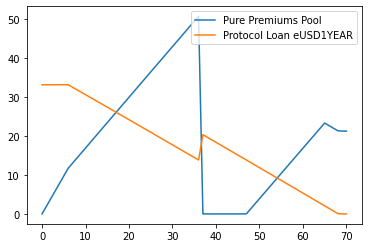

In [11]:
import matplotlib.pyplot as plt

plt.plot(range(len(pure_premiums_by_day)), [x.to_float() for x in pure_premiums_by_day], label='Pure Premiums Pool')
plt.plot(range(len(pure_premiums_by_day)), [x.to_float() for x in protocol_loan_by_day], label='Protocol Loan eUSD1YEAR')
plt.legend()
plt.show()

In [12]:

print(f"eUSD1YEAR total: {eUSD1YEAR.total_supply()}")
print(f"eUSD1MONTH total: {eUSD1MONTH.total_supply()}")
print(f"eUSD1WEEK total: {eUSD1YEAR.total_supply()}")

now = protocol.now()

for ((etoken, lp), (initial_balance, deposit_time)) in deposits_by_lp.items():
    etk = protocol.etokens[etoken]
    balance = etk.balance_of(lp)
    apy = _W(100) * (balance - initial_balance) * _W(SECONDS_IN_YEAR) // (initial_balance * _W(now - deposit_time))
    print(f"LP {lp} {etoken} - Initial: {initial_balance} - Current: {balance} - APY: {apy}")


eUSD1YEAR total: 1023.427885687627434491
eUSD1MONTH total: 1501.780045569056425935
eUSD1WEEK total: 1023.427885687627434491
LP LP1 eUSD1YEAR - Initial: 1000 - Current: 1023.42788568762743449 - APY: 10.302624428896401914
LP LP3 eUSD1WEEK - Initial: 500 - Current: 500.587288338126130735 - APY: 0.579352009232534373
LP LP3 eUSD1MONTH - Initial: 1500 - Current: 1501.780045569056425935 - APY: 0.58533029973477069


In [13]:
USD.balance_of("CUST3")

72